In [38]:
import sys
sys.path.append('..')

from common.util import im2col, col2im
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from dataset.mnist import load_mnist
from common.layers import Relu, Affine, SoftmaxWithLoss
from common.trainer import Trainer

In [3]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(90, 75)


In [39]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.col = None
        self.col_W = None
        
        self.dW = None
        self.db = None
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        
        out = np.dot(col, col_W) + self.b        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx

In [40]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

In [44]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                conv_param={ 'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / \
                            filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                          self.params['b1'],
                                          conv_param['stride'],
                                          conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'],
                                       self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'],
                                       self.params['b3'])

        self.last_layer = SoftmaxWithLoss()
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        acc = 0.0
        for i in range(int(x.shape[0]/ batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)
        return acc / x.shape[0]
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads
    
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [45]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

In [46]:
trainer.train()

train loss:2.299406591747463
=== epoch:1, train acc:0.21, test acc:0.227 ===
train loss:2.2963191553972266
train loss:2.2949874777388457
train loss:2.28657996315364
train loss:2.2765252259693605
train loss:2.2814588031884195
train loss:2.2604824358299394
train loss:2.2388407905574494
train loss:2.2318153477736526
train loss:2.2076590947008548
train loss:2.1525023406755217
train loss:2.1316465511218836
train loss:2.143125287648675
train loss:2.0500546584816863
train loss:2.0281326303809153
train loss:1.9638501639143309
train loss:1.9138321911038465
train loss:1.8618683243247178
train loss:1.804206011642664
train loss:1.7744202294818505
train loss:1.6472023090926535
train loss:1.5866226291364964
train loss:1.4964461501593223
train loss:1.3252233781775318
train loss:1.3444035703617703
train loss:1.3197803705265516
train loss:1.2155220811232303
train loss:1.0874499512116684
train loss:1.028029815311428
train loss:1.0666383975563383
train loss:0.9243144021627714
train loss:0.924409919021170

train loss:0.3220336569125059
train loss:0.28137418412015713
train loss:0.20764701524778706
train loss:0.34324091074653007
train loss:0.22011267041743823
train loss:0.32171287230318063
train loss:0.3603005895970643
train loss:0.3310305342843116
train loss:0.22399848879334425
train loss:0.2539704000587747
train loss:0.3946853124575036
train loss:0.21959743564716053
train loss:0.21659065853334966
train loss:0.15221467740009956
train loss:0.14583814235345371
train loss:0.1705932673305913
train loss:0.2807929032179837
train loss:0.22416942774462803
train loss:0.1489564591975153
train loss:0.15710057643357447
train loss:0.11848892910057925
train loss:0.1885847680229055
train loss:0.2463390421392727
train loss:0.22921602575190012
train loss:0.1949706010304817
train loss:0.21884619626796326
train loss:0.22369199718133387
train loss:0.16851893670554793
train loss:0.1952769731613232
train loss:0.15400388838270024
train loss:0.21807585643804206
train loss:0.12030118808933
train loss:0.2691324812

train loss:0.16619426649656127
train loss:0.056363819810345245
train loss:0.17301176300799648
train loss:0.09457999930038768
train loss:0.07688540615816733
train loss:0.2230932883652713
train loss:0.186296023370812
train loss:0.16733708518623827
train loss:0.08832935631563504
train loss:0.1268302133821289
train loss:0.07942096608428434
train loss:0.06490483312763871
train loss:0.06348093191270379
train loss:0.11835074332608234
train loss:0.21032125163744464
train loss:0.05695734557953889
train loss:0.11361929348611405
train loss:0.06898379581045107
train loss:0.07658931545317867
train loss:0.0673049578367403
train loss:0.10164893164320561
train loss:0.09378741447684379
train loss:0.051331407518016035
train loss:0.06618841671908682
train loss:0.06445299367115301
train loss:0.06800293839198648
train loss:0.058504312488965385
train loss:0.026039649815116608
train loss:0.10751461783600762
train loss:0.09101645087554344
train loss:0.09466641775615306
train loss:0.06490928384615688
train los

train loss:0.12794782210184247
train loss:0.09665760614081527
train loss:0.056802980524723566
train loss:0.05566204833712041
train loss:0.11207167119941577
train loss:0.06864484511184192
train loss:0.05021890612260317
train loss:0.10183602747032258
train loss:0.02083428890297591
train loss:0.04774051693355355
train loss:0.1902660858019494
train loss:0.11723218580959667
train loss:0.1352544630308247
train loss:0.0438999730260164
train loss:0.14907909342949802
train loss:0.05308310464818946
train loss:0.08628842467515396
train loss:0.08600661440019901
train loss:0.03406243896867372
train loss:0.05969317481877184
train loss:0.06730950867118303
train loss:0.06537094426723873
train loss:0.029422089306246617
train loss:0.13160249370661564
train loss:0.10623534585764256
train loss:0.027148755202298966
train loss:0.08751537681578692
train loss:0.14300400564951593
train loss:0.06708455238010687
train loss:0.028435744171624897
train loss:0.06563942150891139
train loss:0.04059045003959831
train l

train loss:0.060207024295924956
train loss:0.03627489461686976
train loss:0.07876015276068603
train loss:0.03994806468909726
train loss:0.013978674979355519
train loss:0.10633632830006173
train loss:0.16715102664494708
train loss:0.03185297967669539
train loss:0.10583671045957538
train loss:0.07212881432675805
train loss:0.05499592997118315
train loss:0.07162098361684434
train loss:0.036137465399218645
train loss:0.041881541151734744
train loss:0.020167581879016714
train loss:0.020430808397384762
train loss:0.047032333558870425
train loss:0.09505041089015333
train loss:0.10420397913185
train loss:0.15951482711949933
train loss:0.11302756253071798
train loss:0.0689558622502522
train loss:0.05000438523004949
train loss:0.06347095307396437
train loss:0.08037593024868427
train loss:0.12342125005648441
train loss:0.05279094759749011
train loss:0.11069983551084585
train loss:0.1334090761603984
train loss:0.02164639758945563
train loss:0.06619262880416653
train loss:0.11346008217426105
train 

train loss:0.042622388430548226
train loss:0.03913376989921972
train loss:0.0231407302173839
train loss:0.0938722162466914
train loss:0.02351250731261683
train loss:0.08175892170592844
train loss:0.16787670263743643
train loss:0.04068562570174156
train loss:0.019413782073682967
train loss:0.0688664436068646
train loss:0.06409178356050967
train loss:0.099151057177302
train loss:0.021058567628627407
train loss:0.13898070136853552
train loss:0.0908405949125982
train loss:0.0343436336952867
train loss:0.013846393202135987
train loss:0.03265631006210525
train loss:0.02627465350314688
train loss:0.02620373515746994
train loss:0.05865950415135423
train loss:0.054125322697079745
train loss:0.026927094912163222
train loss:0.02896753605702713
train loss:0.02759606024971175
train loss:0.041813892043002655
train loss:0.08464087367026916
train loss:0.04667827714297454
train loss:0.021995320240748985
train loss:0.0719516301827007
train loss:0.03621606514886918
train loss:0.01616487367557415
train lo

train loss:0.055956423378915474
train loss:0.033211757955677684
train loss:0.028802599399751928
train loss:0.06117392851092517
train loss:0.04028111118948202
train loss:0.04546506859752241
train loss:0.04070470726148321
train loss:0.014693759624305431
train loss:0.06446081689541812
train loss:0.08266526666940532
train loss:0.04366158088415995
train loss:0.01653258265987113
train loss:0.025174126242522882
train loss:0.030820337474741267
train loss:0.022150358275146057
train loss:0.037270160267389565
train loss:0.013508299678598366
train loss:0.04603031563444472
train loss:0.034612278014757546
train loss:0.085349004908997
train loss:0.018669843473248265
train loss:0.0724818401009769
train loss:0.0567100663464603
train loss:0.012065634236539906
train loss:0.009949333181577404
train loss:0.07803603747785601
train loss:0.05821560711021724
train loss:0.0432797260351966
train loss:0.004754593780153193
train loss:0.037301124333219624
train loss:0.02030646345518347
train loss:0.0260262385539875

train loss:0.06375586800042647
train loss:0.005249741721228802
train loss:0.00899434375871989
train loss:0.012769592912823551
train loss:0.02654093809741395
train loss:0.009578102000549532
train loss:0.07604368293524338
train loss:0.01329078406829161
train loss:0.02154435501992364
train loss:0.032184937519131006
train loss:0.020096220951939695
train loss:0.031094394915680876
train loss:0.06828931917141715
train loss:0.040403498999917034
train loss:0.050767507430758564
train loss:0.040970947855983104
train loss:0.023351866345109315
train loss:0.010748671543802192
train loss:0.008067962551584002
train loss:0.03986464947519988
train loss:0.08893738563938956
train loss:0.024638373541300513
train loss:0.019788468575508776
train loss:0.03775988712548685
train loss:0.03100492420161432
train loss:0.031627943789256714
train loss:0.0069836152608883754
train loss:0.011785395163894255
train loss:0.04621355435118708
train loss:0.08902318844145457
train loss:0.014612610046251896
train loss:0.0120979

train loss:0.008704831641116455
train loss:0.03919762607057118
train loss:0.02029692585081899
train loss:0.031023287674570136
train loss:0.01711972275961463
train loss:0.02104065734349842
train loss:0.01541336564782689
train loss:0.04093731218171064
train loss:0.0273880803021898
train loss:0.018194783231644536
train loss:0.006674437256687333
train loss:0.055750330435571
train loss:0.06870065120272914
train loss:0.019770124516286725
train loss:0.014971626397848216
train loss:0.06948712359920767
train loss:0.05301192138580268
train loss:0.008907701384553473
train loss:0.06299391881517678
train loss:0.06925848641783382
train loss:0.015554219025244788
train loss:0.035073648530448004
train loss:0.01379182148538183
train loss:0.01689550853195915
train loss:0.019512674369907806
train loss:0.03554646515464281
train loss:0.027119760971605653
train loss:0.0330457110308891
train loss:0.07136052256348187
train loss:0.028684240034044222
train loss:0.007984439495250517
train loss:0.04159973228226979

train loss:0.030807355727934502
train loss:0.01258249115860152
train loss:0.03177972931432729
train loss:0.0037851170465479254
train loss:0.024947407347681607
train loss:0.02885000672442471
train loss:0.009272636517790428
train loss:0.024942188703963152
train loss:0.03253770823275942
train loss:0.018367855774968904
train loss:0.009713353886682654
train loss:0.037607711238865756
train loss:0.08619917713205343
train loss:0.00973786416502061
train loss:0.011600985256421614
train loss:0.023082292843704513
train loss:0.04244361994649431
train loss:0.027507775629732733
train loss:0.05569381354270783
train loss:0.007572227530097405
train loss:0.029929122604964248
train loss:0.0407340455877632
train loss:0.020275511478414915
=== epoch:5, train acc:0.989, test acc:0.98 ===
train loss:0.025103107169586622
train loss:0.005240403138353539
train loss:0.0075244392640288794
train loss:0.022752369652612986
train loss:0.03120768993376449
train loss:0.014659531605945826
train loss:0.07075772442392224
tr

train loss:0.01856044280030759
train loss:0.01411440899306205
train loss:0.008064271801950483
train loss:0.048255783037464604
train loss:0.01919087172873136
train loss:0.004147705568398169
train loss:0.03234404990633384
train loss:0.025895369709214276
train loss:0.003070479116090666
train loss:0.012123483527536429
train loss:0.09678968718858219
train loss:0.016598401221695903
train loss:0.012744132231098427
train loss:0.06065232894247616
train loss:0.021223916204800422
train loss:0.019719100132220092
train loss:0.01843267636613811
train loss:0.07958661726314603
train loss:0.003623116629039824
train loss:0.010987066737015183
train loss:0.008774839400074966
train loss:0.06457452718397098
train loss:0.03466897280604822
train loss:0.016160546650297904
train loss:0.03104966453070531
train loss:0.005318836793342468
train loss:0.04203236362220298
train loss:0.10645366178186347
train loss:0.04302160841495253
train loss:0.053214499567416286
train loss:0.003527408718859729
train loss:0.014622399

train loss:0.009027358583612111
train loss:0.008088281494488474
train loss:0.020859527641094285
train loss:0.03516632110471213
train loss:0.021800577565447146
train loss:0.012017807609858022
train loss:0.014748241370732702
train loss:0.019886099952061916
train loss:0.01192079941652926
train loss:0.009825117060735104
train loss:0.018275308816686812
train loss:0.018600068337342988
train loss:0.01575386093671682
train loss:0.005828846509440717
train loss:0.008138147288255728
train loss:0.0077436060420084715
train loss:0.009918862037369075
train loss:0.009179985183592077
train loss:0.017456532368619583
train loss:0.029741546460354915
train loss:0.09381427750994124
train loss:0.022877885857290857
train loss:0.005957507755497491
train loss:0.010853091621145974
train loss:0.03376451557014317
train loss:0.0062389139953034425
train loss:0.006432845603891596
train loss:0.01090550939655045
train loss:0.005153055586359759
train loss:0.02494141017753858
train loss:0.002059143132731526
train loss:0.

train loss:0.04336408926642447
train loss:0.016459781648766932
train loss:0.0037922647583634238
train loss:0.01939620904034029
train loss:0.016402772305980667
train loss:0.05114726505569338
train loss:0.007109947697122758
train loss:0.008089950167817725
train loss:0.014180319790950899
train loss:0.0116727354069156
train loss:0.015881565335665516
train loss:0.039259916102843614
train loss:0.02717679130334301
train loss:0.004556099004993785
train loss:0.007723183894771233
train loss:0.054529364206205716
train loss:0.020721564532493825
train loss:0.011661118742970973
train loss:0.0053972585333650945
train loss:0.013825796957528981
train loss:0.025330093972634745
train loss:0.007734072920709772
train loss:0.0070545658268908965
train loss:0.017478850269197325
train loss:0.005797795153007497
train loss:0.018426100377626313
train loss:0.02290226623947655
train loss:0.01599453667178952
train loss:0.022062746736173394
train loss:0.00522892782059247
train loss:0.016031936638224255
train loss:0.0

train loss:0.004588274786289425
train loss:0.025450368530432147
train loss:0.0197328618872099
train loss:0.016444634362329423
train loss:0.022557714584104688
train loss:0.01104827966225054
train loss:0.002429480590889149
train loss:0.03299365149070909
train loss:0.021482157481651692
train loss:0.015258847037073042
train loss:0.006000190379174863
train loss:0.00411388690848531
train loss:0.0032171572936779565
train loss:0.005080402559799612
train loss:0.037224147837537795
train loss:0.007796711239683679
train loss:0.026377566011576866
train loss:0.06079818229176993
train loss:0.00634539603336508
train loss:0.010422722488056153
train loss:0.009935626032910759
train loss:0.006825560467416317
train loss:0.017865295004787757
train loss:0.005137295472707776
train loss:0.08187755647063398
train loss:0.001991753639993481
train loss:0.014679178898682041
train loss:0.022297016588133566
train loss:0.009815463108445818
train loss:0.01284535007415026
train loss:0.0016267013006633735
train loss:0.00

train loss:0.015049299026872744
train loss:0.010845042659498115
train loss:0.015269437102983754
train loss:0.02729900599315624
train loss:0.01186695787911065
train loss:0.0036877088291152925
train loss:0.012753289942352555
train loss:0.030947046697597798
train loss:0.01338457242706597
train loss:0.011741915605091942
train loss:0.0185510474796926
train loss:0.025907421744117646
train loss:0.004976191018969831
train loss:0.011852851955683419
train loss:0.0015307889530199775
train loss:0.006780625661295943
train loss:0.08535691009614714
train loss:0.03055361817198973
train loss:0.012036253716641552
train loss:0.00992214683646132
train loss:0.0034514206510851907
train loss:0.04394568925399388
train loss:0.008470214301324549
train loss:0.01786503909626712
train loss:0.04384360512949512
train loss:0.010516668539056735
train loss:0.006021143872951994
train loss:0.0034541736683437697
train loss:0.049166724636552445
train loss:0.015607708061185993
train loss:0.00718363116329458
train loss:0.012

train loss:0.007821956885309518
train loss:0.004676040751828811
train loss:0.008440757997953961
train loss:0.003339349219663673
train loss:0.03256367798828039
train loss:0.005858499291850725
train loss:0.02077468286567887
train loss:0.0038703797854292483
train loss:0.012602659483408137
train loss:0.010078421497195327
train loss:0.00496313820113101
train loss:0.01805690541827855
train loss:0.03441365483861848
train loss:0.01031246255821782
train loss:0.007152866100187454
train loss:0.0037791136628503768
train loss:0.04898893404089666
train loss:0.008340720855139117
train loss:0.009938307457303978
train loss:0.005855960449633844
train loss:0.013840349028243812
train loss:0.012014293809695795
train loss:0.008433553586796462
train loss:0.0018771566980947418
train loss:0.004336554398602391
train loss:0.02999862976369202
train loss:0.006433414491023744
train loss:0.005332045775464612
train loss:0.00916856442566897
train loss:0.0051043554175284915
train loss:0.034241361727731894
train loss:0.

train loss:0.001824082419450606
train loss:0.00522289169549653
train loss:0.0070380372233625164
train loss:0.0051579342358126145
train loss:0.004104534783795128
train loss:0.017116088644802695
train loss:0.05380673826852966
train loss:0.008937329669509499
train loss:0.002437304603321402
train loss:0.033396321503763864
train loss:0.040545452406718974
train loss:0.003239238564365698
train loss:0.0075056765700812315
train loss:0.005946135749848714
=== epoch:8, train acc:0.991, test acc:0.985 ===
train loss:0.025971130435175196
train loss:0.005391920288831605
train loss:0.010734445684281406
train loss:0.004640770622841006
train loss:0.010529498585638673
train loss:0.012559448116793315
train loss:0.024084028235797982
train loss:0.007038738895874955
train loss:0.008567695661177065
train loss:0.0040219592931725785
train loss:0.0012319010571438028
train loss:0.012891441105096189
train loss:0.0033036701076021467
train loss:0.040578212786530496
train loss:0.0029661672586572337
train loss:0.00213

train loss:0.008099970199376597
train loss:0.0028121552753768795
train loss:0.05490443671790333
train loss:0.00243755442926349
train loss:0.004604112271322555
train loss:0.008604284358978379
train loss:0.010780718966566983
train loss:0.003908435704095576
train loss:0.10329342776216636
train loss:0.006152471658807306
train loss:0.00234579421349401
train loss:0.010984921843701305
train loss:0.007954593574004888
train loss:0.006888681158718883
train loss:0.011107788141386053
train loss:0.02971412232196523
train loss:0.0022359805970913697
train loss:0.013584829645243943
train loss:0.003891474216494648
train loss:0.0018820328904348815
train loss:0.00658884132322899
train loss:0.0035389310815833806
train loss:0.0025800009768229544
train loss:0.006887330935571204
train loss:0.0013044420639084986
train loss:0.0028602085052852615
train loss:0.008244844829793416
train loss:0.014402051629890436
train loss:0.00047742315991593947
train loss:0.026755021074274524
train loss:0.0029226543028818565
trai

train loss:0.024132310193274158
train loss:0.005389802030976809
train loss:0.003698076082223883
train loss:0.00441557424816386
train loss:0.012583440946143826
train loss:0.02331287218789817
train loss:0.005260562641090105
train loss:0.0035854946648881583
train loss:0.027902542506302152
train loss:0.011100979895332848
train loss:0.01587633580296389
train loss:0.018982729714336406
train loss:0.03051454433267555
train loss:0.014609270271734002
train loss:0.007881492155194519
train loss:0.04020027346131986
train loss:0.007360792521120273
train loss:0.039803233351801144
train loss:0.012406623305718128
train loss:0.014079176544438281
train loss:0.017462502451999356
train loss:0.03635988974661727
train loss:0.009562015380465708
train loss:0.03647607388388324
train loss:0.007038100491621751
train loss:0.015819876506561813
train loss:0.03879020323255921
train loss:0.054994201405373914
train loss:0.00878257694677313
train loss:0.06441834283143937
train loss:0.011727332397508559
train loss:0.0085

train loss:0.04747190011056574
train loss:0.001744202626572961
train loss:0.003809560414707081
train loss:0.04389663792842352
train loss:0.0011769595025519896
train loss:0.0010745170194364107
train loss:0.002293210668745531
train loss:0.0016820993415483107
train loss:0.002753696360427935
train loss:0.007759282342848314
train loss:0.0046575194595135545
train loss:0.005792984579941798
train loss:0.020107145394076053
train loss:0.009299665550766674
train loss:0.004057529007402826
train loss:0.0012696110060749807
train loss:0.03918556113009521
train loss:0.01746317355377459
train loss:0.0035428101525222877
train loss:0.013877604605018577
train loss:0.003294545267677329
train loss:0.013038446841205502
train loss:0.020679331482318774
train loss:0.011994754390980846
train loss:0.005939836555941852
train loss:0.00835909441682179
train loss:0.004034898009790455
train loss:0.013296803432737115
train loss:0.0029042169250405327
train loss:0.0016264057977204282
train loss:0.0035580361844845822
trai

train loss:0.01588236482883298
train loss:0.1700790670310331
train loss:0.005115444243234589
train loss:0.005059451956405902
train loss:0.025597798952972862
train loss:0.008208276196418188
train loss:0.0014877091120116142
train loss:0.010300856619973103
train loss:0.002835419733604303
train loss:0.0019939206754905027
train loss:0.005266688144812659
train loss:0.005463020888702631
train loss:0.010255331126916256
train loss:0.0021925827799426424
train loss:0.000915493782520986
train loss:0.00029267889408408
train loss:0.004983373425683597
train loss:0.03343598330984666
train loss:0.001087660450300627
train loss:0.012096850377016721
train loss:0.004749266217293176
train loss:0.005454127998425421
train loss:0.006056540847895407
train loss:0.004488085252083949
train loss:0.005589324864832446
train loss:0.002655214057418702
train loss:0.005291809616326999
train loss:0.002058949446699104
train loss:0.010575981494202545
train loss:0.0020236200993320862
train loss:0.00850021943117213
train loss

train loss:0.011237157567739138
train loss:0.005482871187576784
train loss:0.02065421649305334
train loss:0.003413637107476208
train loss:0.0011914926606760184
train loss:0.0014153444926867354
train loss:0.002612358188959137
train loss:0.0036348586877175204
train loss:0.014628849037066622
train loss:0.02021867684225542
train loss:0.0034297500260582555
train loss:0.004884394066806955
train loss:0.021852912272548815
train loss:0.00931568238217011
train loss:0.002445951814380016
train loss:0.012051981606299712
train loss:0.011325170875403561
train loss:0.021137059752582305
train loss:0.0272933405849629
train loss:0.0024850653119828222
train loss:0.003205001549443787
train loss:0.008670018339684428
train loss:0.0015494208839311927
train loss:0.00464259207109487
train loss:0.009041117163749855
train loss:0.0035176181885690455
train loss:0.010506386526138698
train loss:0.0019128617330405955
train loss:0.001387309071039511
train loss:0.02560178994229551
train loss:0.03848884694796709
train lo

train loss:0.01874127377146492
train loss:0.005732320536440228
train loss:0.002608905766331634
train loss:0.0007713811114784839
train loss:0.006201275896391061
train loss:0.008268884481088734
train loss:0.003275299136836765
train loss:0.0037891548530383963
train loss:0.006558413040858171
train loss:0.007028419530867148
train loss:0.033655865981459886
train loss:0.0020938310486640272
train loss:0.01841119980940007
train loss:0.0004221861865354716
train loss:0.0011253994055388072
train loss:0.0037167636299439504
train loss:0.0018981009389609166
train loss:0.0020015807866902006
train loss:0.01000473253492826
train loss:0.03385816780897989
train loss:0.033607384788865956
train loss:0.002913876529705588
train loss:0.0012492250611517452
train loss:0.005613285500005909
train loss:0.01956820199620798
train loss:0.0011968437113661764
train loss:0.001199790878952046
train loss:0.0009449103855251164
train loss:0.005298921665188408
train loss:0.013806206938720651
train loss:0.008076590729944107
tr

train loss:0.0012826608080432394
train loss:0.005370725737518494
train loss:0.01956463908749211
train loss:0.012972659184124984
train loss:0.0009124721773754075
train loss:0.011460467563261174
train loss:0.001186569298368014
train loss:0.003103068876156177
train loss:0.00038827412245970853
train loss:0.010696159276307982
train loss:0.005029504411405506
train loss:0.0027794174678383455
train loss:0.0017646260346352402
train loss:0.00796050490603682
train loss:0.01039662295870477
train loss:0.023178553336108444
train loss:0.0047592673449708715
train loss:0.017002109940482107
train loss:0.0029017221266518928
train loss:0.012172302607139371
train loss:0.0017847249640396594
train loss:0.0029574587667405105
train loss:0.013195812042624393
train loss:0.008379932899823667
train loss:0.0036001765545318424
=== epoch:11, train acc:0.994, test acc:0.987 ===
train loss:0.0004384893810722918
train loss:0.000977000273250386
train loss:0.0012661753701333181
train loss:0.0012221894985873854
train loss:

train loss:0.004899823859877617
train loss:0.0013570418525707215
train loss:0.005131453004510966
train loss:0.006430805780234761
train loss:0.0040788388009144905
train loss:0.0040651201180014725
train loss:0.008516761246565807
train loss:0.0055937902970712
train loss:0.09198141629342556
train loss:0.11428889543266237
train loss:0.006257013900226642
train loss:0.002585419114255904
train loss:0.0035286437525557856
train loss:0.007339794182963105
train loss:0.006774604115177985
train loss:0.008049048497666045
train loss:0.0011363191139644904
train loss:0.007280647479059015
train loss:0.004728543277159882
train loss:0.0041349953345177085
train loss:0.001357127178038776
train loss:0.008268721758178478
train loss:0.000879558533561289
train loss:0.001164828722126459
train loss:0.0009173673400053522
train loss:0.0009317685307795162
train loss:0.004787640455927078
train loss:0.01779934615183243
train loss:0.0064624285439004135
train loss:0.01643993533239257
train loss:0.007214873181325571
train

train loss:0.015960573073602716
train loss:0.0009118754545570973
train loss:0.002170875618730024
train loss:0.0008187171340242074
train loss:0.00866414095850232
train loss:0.0123938206747029
train loss:0.003290856807102282
train loss:0.001707974170643176
train loss:0.0030581206556138936
train loss:0.002226565363359245
train loss:0.00817282804269265
train loss:0.0010376045507864819
train loss:0.001958944015282659
train loss:0.04605794265301992
train loss:0.0003997507972033074
train loss:0.006392849164454721
train loss:0.00908289452956586
train loss:0.008155440085938737
train loss:0.007056011964104641
train loss:0.009621012896090412
train loss:0.0011253527321723423
train loss:0.0004268430575475086
train loss:0.0015079687239380594
train loss:0.006651459146790864
train loss:0.015812579738285364
train loss:0.0020462054118997935
train loss:0.004599914835743444
train loss:0.019127804389626305
train loss:0.0009910724684723002
train loss:0.00454647994924037
train loss:0.0007745142520117354
trai

train loss:0.002930263521887051
train loss:0.0015126705266599939
train loss:0.0032217899519352165
train loss:0.0027099394040189556
train loss:0.005116642059688977
train loss:0.0021292687100077793
train loss:0.0005692306385051337
train loss:0.002332903481105425
train loss:0.011057455000598763
train loss:0.0001686046099720257
train loss:0.0002914427333112298
train loss:0.007733083138625516
train loss:0.01940527145062016
train loss:0.0013697731973361087
train loss:0.0006539946609562309
train loss:0.0462179384978708
train loss:0.0015068321063330108
train loss:0.015106113474378619
train loss:0.02542230717670126
train loss:0.002785546947537966
train loss:0.0012368106378348365
train loss:0.0011820295693904053
train loss:0.0032647354613740977
train loss:0.0058643239198773855
train loss:0.002388070093274211
train loss:0.0005055815187875599
train loss:0.00544847219010154
train loss:0.006812214201402363
train loss:0.022419368607532335
train loss:0.028632736275381734
train loss:0.00261466068963509

train loss:0.0015271351573923923
train loss:0.009937872443899825
train loss:0.0009367567816871121
train loss:0.0019382632045397976
train loss:0.10765867980116439
train loss:0.001780518962116589
train loss:0.0021839977961124264
train loss:0.0041981779661751165
train loss:0.0022839731634466966
train loss:0.0020229206637402486
train loss:0.0009615613288835933
train loss:0.004653492575670694
train loss:0.0051629055251732866
train loss:0.003095121711827312
train loss:0.0013565218668938896
train loss:0.002226159974493138
train loss:0.002825454426915001
train loss:0.004935934294991489
train loss:0.004632241408732049
train loss:0.0035568126572947
train loss:0.005401956096308848
train loss:0.00862202692347376
train loss:0.007901781960014344
train loss:0.001080761866625472
train loss:0.002850309847229341
train loss:0.0011932277254616127
train loss:0.0009904526156551297
train loss:0.0007341519473869806
train loss:0.02019913557891266
train loss:0.000752034336244794
train loss:0.0033504349462265787

train loss:0.008166340484287365
train loss:8.757587059943484e-05
train loss:0.004242040751280325
train loss:0.0035346194288850335
train loss:0.017002901081384806
train loss:0.010657731955393655
train loss:0.0004485991072942832
train loss:0.0038287641759302033
train loss:0.00442023999372537
train loss:0.0015550986672835437
train loss:0.004339122875078856
train loss:0.0017646981703990667
train loss:0.047192239049877766
train loss:0.0031803698506532533
train loss:0.0019695368253116203
train loss:0.04357756313222889
train loss:0.0017801653812847319
train loss:0.002577742714748762
train loss:0.002621010051206904
train loss:0.002539889653001323
train loss:0.0015549257245785894
train loss:0.00046243131691027734
train loss:0.002255048520034547
train loss:0.0019577999807442524
train loss:0.006941926209192167
train loss:0.00023893912423011353
train loss:0.001554910526445017
train loss:0.007203865643091586
train loss:0.007166033776849367
train loss:0.005640385598051389
train loss:0.00077565581328

train loss:0.0018367629838899615
train loss:0.0021957789511010003
train loss:0.0017513931167355348
train loss:0.003106729864061335
train loss:0.0013678456397330707
train loss:0.002946806604396684
train loss:0.0004812118611232001
train loss:0.0014820493111283527
train loss:0.0007232528505628587
train loss:0.0053932253864465984
train loss:0.0008619431917828915
train loss:0.0009813921196416332
train loss:0.0030411258849268813
train loss:0.0033385851888283725
train loss:0.006543458496471006
train loss:0.001618671370252659
train loss:0.0030422849275077712
train loss:0.0015112303934236928
train loss:0.0012490864887063444
train loss:0.002671299795259801
train loss:0.0031363622490478728
train loss:0.0013417369739287615
train loss:0.012197683902192866
train loss:0.003135083386314995
train loss:0.000860386416417546
train loss:0.0006289016181062274
train loss:0.00280173583234658
train loss:0.0005547300845382045
train loss:0.0007820384450569084
train loss:0.0023842145837834183
train loss:0.0053277

train loss:0.0004444830160264907
train loss:0.0012836675904393184
train loss:0.0005899985163382792
train loss:0.003600422960773276
train loss:0.0017913132167266086
train loss:0.002647086131507784
train loss:0.005234393340271628
train loss:0.0016046007157404201
train loss:0.003969229720165166
train loss:0.00024455555274798067
train loss:0.0005207717254534917
train loss:0.003599455812944096
train loss:0.003957251108408284
train loss:0.003000173656342757
train loss:0.004013403209374537
train loss:0.00034144360325643117
train loss:0.0004927108994030024
train loss:0.023815280269196486
train loss:0.0012296805821320248
train loss:0.0006645492228826185
train loss:0.0036506389468746138
train loss:0.0032038430236192655
train loss:0.006661351076723644
train loss:0.0038372715172562406
train loss:0.000715550992777439
train loss:0.0004970280462020312
train loss:0.00041900027834527087
train loss:0.004072902373748314
train loss:0.0006619017213413822
train loss:0.0016222113972402625
train loss:0.003266

train loss:0.0018069069280020706
train loss:0.00210173982368738
train loss:0.0014914396164955178
train loss:0.00024501048357776733
train loss:0.00018970872372914703
train loss:0.013210145090983687
train loss:0.0007792441840097859
train loss:0.0010624042089230257
train loss:0.014081887344394105
train loss:0.007321605830802439
train loss:0.00019396903002001038
train loss:0.0008243573858651784
train loss:0.0020346972979447125
train loss:0.0010690648669908999
train loss:0.0032458609297544407
train loss:0.0009259814824424842
train loss:2.880305331052978e-05
train loss:0.0007646500938056172
train loss:0.032086504352788495
train loss:0.002348414780505051
train loss:0.001326255498638296
train loss:0.001949998179045262
train loss:0.011621153654649026
train loss:0.0034352133245578514
train loss:0.004866934480521746
train loss:0.003525491072433351
train loss:0.00013393785587135254
train loss:0.0003376257785382876
train loss:0.006844835965339602
train loss:0.0011350515064621138
train loss:0.005792

train loss:0.0072521135741536215
train loss:0.0024137965201597718
train loss:0.003295510222022894
train loss:8.541329466863928e-05
train loss:0.0003764448863995179
train loss:0.00909785210780001
train loss:0.001070369070932243
train loss:0.0001756415649084165
train loss:0.0037827137003441365
train loss:0.0006407954698855763
train loss:0.026938863234016164
train loss:0.00038274513300160136
train loss:0.020857687605567346
train loss:0.0010116610934318801
train loss:0.000228168672303711
train loss:0.015599245142710893
train loss:0.0032763076419262504
train loss:0.0027317074635298103
train loss:0.0009525614586571871
train loss:0.0026065246803021647
train loss:0.006434649055126163
train loss:0.0030096514700511
train loss:0.006621136645116202
train loss:0.0043160907767873504
train loss:0.007535405401699165
train loss:0.0026572830269791636
train loss:0.001255727866563143
train loss:0.0015939767137815985
train loss:0.0026587410887417536
train loss:0.005659088075041494
train loss:0.002044547221

train loss:0.0022164628401977037
train loss:0.001416537086784879
train loss:0.00030132597801867285
train loss:0.0002186543579534651
train loss:0.0063276300291632255
train loss:0.000786749231324287
train loss:0.0013248955375325337
train loss:0.003554369618446665
train loss:7.198742017079863e-05
train loss:0.0005505307399629426
train loss:0.0010932455145071887
train loss:0.002267242952463186
train loss:0.0016782045762974076
train loss:0.00023977465280902203
train loss:0.000178951662199479
train loss:0.0018382705937085538
train loss:0.0012708214199650396
train loss:0.0007123630147864664
train loss:0.0008721879769158638
train loss:0.0011434462835493264
train loss:0.0031055874826330498
train loss:0.0007960451890720502
train loss:0.004594339181819588
train loss:0.0026336618450597386
train loss:0.0001593932268561854
train loss:0.0016461691944430986
train loss:0.002569958652339156
train loss:0.0011711606907728299
train loss:0.00032033815072024464
train loss:0.0008362116511362435
train loss:0.0

train loss:0.0002760787134208117
train loss:0.0024319922855127697
train loss:0.000701570327039778
train loss:0.00486141435494935
train loss:0.0009329115397117162
train loss:0.0006814092209087283
train loss:0.002801180491587254
train loss:0.0031885736998568397
train loss:0.0001837989829514706
train loss:0.0010495038429520283
train loss:0.001233371259066928
train loss:0.0016879789675066919
train loss:0.003971008436687063
train loss:0.00025683340703392093
train loss:0.001507243704854416
train loss:0.002562282798178414
train loss:0.0015741329583549562
train loss:0.001919071844691009
train loss:0.000630740338777181
train loss:6.877821032854241e-05
train loss:0.0016650482894366673
train loss:0.00027711532441259117
train loss:0.04302872315351285
train loss:0.00046289883607636954
train loss:0.0034996408606123514
train loss:7.811617194272415e-05
train loss:0.00029345905496706235
train loss:0.001967483530388887
train loss:0.002410139174788718
train loss:7.441461656695958e-05
train loss:0.0032518

train loss:0.00035161316224332204
train loss:0.0014402393792575957
train loss:0.0005292781579940856
train loss:0.002090067011633957
train loss:0.0002075332026739443
train loss:0.0031166627689682685
train loss:0.0030410711181420064
train loss:0.0018258571147555204
train loss:0.0010975747954800044
train loss:0.0002924490828297604
train loss:0.0012610917957626008
train loss:9.122165535709468e-05
train loss:0.0022148305067223374
train loss:0.0012289133719419285
train loss:0.001354843294350153
train loss:0.0002384372355378024
train loss:0.003050353141387471
train loss:0.0015610454690393532
train loss:0.011416727084408827
train loss:0.0022072195724320183
train loss:0.0033218424709197
train loss:0.0006018492877098977
train loss:0.00019702794325695956
train loss:0.00030188045258190097
train loss:0.004009974202155043
train loss:0.001896052002490844
train loss:1.1013651914417568e-05
train loss:0.0013758830277887956
train loss:0.0002812869527010664
train loss:0.0004779657827016868
train loss:0.00

train loss:0.011019606288799423
train loss:0.0003155198430900525
train loss:0.0015492927003185417
train loss:0.003722475944762443
train loss:0.0003656899036827121
train loss:0.00020102525366167735
train loss:0.0027319670593841856
train loss:0.005127233470590163
train loss:0.002042060742528913
train loss:0.0007459398102692269
train loss:0.0011451943542298785
train loss:0.006544419006920052
train loss:0.0032452754199770464
train loss:0.0036931788589405117
train loss:0.00026670990002805665
train loss:0.0035783507322685796
train loss:0.007356317756725571
train loss:0.0043117174511739745
train loss:0.0004397244059731415
train loss:0.0005916425600676193
train loss:0.0022644770912382418
train loss:0.0010237280445150685
train loss:0.0014862864633465867
train loss:0.0006114183499169458
train loss:0.00035805146998291334
train loss:0.006760118201401623
train loss:0.002341673583771893
train loss:0.038465027220111664
train loss:0.0025868362501470506
train loss:0.0008363813453550892
train loss:0.005

train loss:0.0033433833859938733
train loss:0.00040759839295925163
train loss:0.0016987588800183092
train loss:0.00025680626247876685
train loss:0.0020297479420541323
train loss:0.0016191060278789387
train loss:0.0022865066040091185
train loss:0.0011775116137060558
train loss:0.0005404057713510286
train loss:0.002128188629987437
train loss:3.624778481357037e-05
train loss:0.001786858985763632
train loss:0.0001945117441758839
train loss:0.000848732246156408
train loss:0.003410936564942002
train loss:0.0002652490668179243
train loss:0.0006202461378170789
train loss:0.00024386729895322867
train loss:0.0010861289790713572
train loss:0.0030514607543969067
train loss:0.003624011607871254
train loss:0.0015375547456471378
train loss:0.001565916530743331
train loss:0.0022933768490317327
train loss:0.0017697560080599006
train loss:0.005277503732410998
train loss:0.01095556124028209
train loss:0.0016696737717704208
train loss:0.0027320135384736374
train loss:0.0005297085662325493
train loss:0.005

train loss:0.0009885234007342327
train loss:0.004456486043817213
train loss:0.005262889740125156
train loss:0.000354295466046114
train loss:0.00800156886281534
train loss:0.00024823129182585636
train loss:0.0002491365676739037
train loss:0.007648894787215252
train loss:0.0009748758259295669
train loss:0.0011982565596433065
train loss:0.005640062312278161
train loss:0.0003795846045440674
train loss:0.002177337991476053
train loss:0.016566291491891552
train loss:0.001480188696779213
train loss:0.004878797811058048
train loss:0.00024408874915498522
train loss:0.010581981316891597
train loss:0.0008693168146442268
train loss:0.0005967126205931065
train loss:0.0172344259959399
train loss:0.010787130192963448
train loss:0.0016542079918213004
train loss:0.00859116169726041
train loss:0.0047327508195562
train loss:0.0028819808034091423
train loss:0.0002423592527672639
train loss:0.0007298594808127331
train loss:0.0020545544401118997
train loss:0.00029924881584429263
train loss:0.001615024799591

train loss:0.006674462780524925
train loss:0.00041851470607585256
train loss:0.0025857531629158857
train loss:0.0011574511655592739
train loss:0.00045504010831004077
train loss:0.0013192315277285576
train loss:0.0010975124627860982
train loss:8.50026336254732e-05
train loss:0.001998029990281427
train loss:0.0015476050240758093
train loss:0.002428098136316271
train loss:0.0011959810327247767
train loss:0.0007298850186117708
train loss:0.0011927048681616647
train loss:0.0005110022877763515
train loss:0.0017630470394094802
train loss:0.0074926987845848215
train loss:0.00022403105394260125
train loss:0.001385135560303245
train loss:0.001605002024663018
train loss:0.0003234782388653779
train loss:0.0013944967086347286
train loss:0.0002495902236488458
train loss:0.0014048553982359572
train loss:0.0013069278666178396
train loss:0.0009494337704003018
train loss:0.0002695365592875929
train loss:0.001562564355373642
train loss:0.001671533375056191
train loss:0.00012695289997196465
train loss:0.0

train loss:0.0013686632945411365
train loss:0.00218755102220212
train loss:0.0002226308055079824
train loss:0.0008505628840913553
train loss:0.00021315983434984001
train loss:0.001791589455013772
train loss:6.806891891467654e-05
train loss:0.0010900634769741512
train loss:0.000818005722365773
train loss:0.0006797070797267388
train loss:0.0025539885730103346
train loss:0.0006280695410247804
train loss:0.0012820753773870872
train loss:0.0021798388916946217
train loss:0.0001537542270308675
train loss:0.0010848440137410783
train loss:0.0014383080694041362
train loss:0.000403931145892014
train loss:0.0002223657055010788
train loss:0.0007177288488260225
train loss:0.0007496979249419652
train loss:0.0009342698704775754
train loss:0.0002993680621002369
train loss:0.018151274001489824
train loss:0.0005235244107844836
train loss:0.0023019080635414356
train loss:0.00023112670747483448
train loss:0.0012711491723911702
train loss:0.04958620397583025
train loss:0.001011251117767119
train loss:0.0002

train loss:0.001497478229804983
train loss:0.0017722941500071976
train loss:0.0008323697584804547
train loss:0.0009505726097382791
train loss:0.0036818410780788103
train loss:0.002205294794622486
train loss:4.8425825755312515e-05
train loss:0.00039932458128794584
train loss:0.00011788291265809524
train loss:0.0009121710208880539
train loss:0.0010126808611276442
train loss:0.00029404519375720613
train loss:0.00017429314932641216
train loss:0.0005568759407420641
train loss:0.0007835379525766141
train loss:0.0011114824041274633
train loss:0.003187195360270624
train loss:0.00606722821978807
train loss:0.0004303269878432308
train loss:0.0001413743472197972
train loss:0.00013517155480293158
train loss:0.0025109842408385717
train loss:0.0006455986449960484
train loss:0.0014201784127956469
train loss:0.00023022784879116054
train loss:0.002019151685518965
train loss:0.0003592737146196092
train loss:0.0017581116752527493
train loss:0.00018263728192402528
train loss:0.0019082687397370104
train lo

train loss:0.0024567496259580153
train loss:0.00207511961266468
train loss:0.0034513217318332683
train loss:0.0014922122547259547
train loss:0.00443343686266554
train loss:0.004842330580116367
train loss:0.003793972018346808
train loss:0.002634268160685718
train loss:0.0010128264863361143
train loss:0.0015795010915964217
train loss:0.0013929413651555444
train loss:0.00010829631363711345
train loss:0.0016506303051326537
train loss:0.002406961424479269
train loss:0.0007603278237567759
train loss:0.001510940992707932
train loss:0.00036389077961758795
train loss:0.0009482451992572255
train loss:0.000619607738145364
train loss:0.0013872364282167793
train loss:0.002008738401782071
train loss:0.0011183843948355942
train loss:0.0006527932465360835
train loss:0.0003011839446537718
train loss:5.530632423847796e-05
train loss:9.840925411517503e-05
train loss:0.0027923242620545787
train loss:0.000884619377569619
train loss:0.00012594622798993101
train loss:0.0033233455091292844
train loss:0.000577

train loss:0.0008510791879720751
train loss:0.0011239757427701134
train loss:0.00011660047407857348
train loss:0.0004103093680055094
train loss:0.000366436665271743
train loss:2.5400889218426818e-05
train loss:0.001667728792072981
train loss:0.0006454384666320581
train loss:0.0002143588810203849
train loss:4.408208043322497e-05
train loss:8.865893155804911e-05
train loss:0.02838576547978993
train loss:0.0002044207618312923
train loss:0.0011127127327659244
train loss:0.0040409943458159184
train loss:0.0016830128839945585
train loss:0.00024106933252844215
train loss:0.0015182413288706547
train loss:2.608114664432463e-05
train loss:0.0006499777491195759
train loss:0.0004468234400807825
train loss:0.0011456614411526624
train loss:6.997864546949507e-05
train loss:0.0008494212186731353
train loss:0.0002028041633757629
train loss:0.00341898517455716
train loss:0.0025774594149440043
train loss:0.0031046224119537953
train loss:0.0019051106336072988
train loss:0.00525507140133368
train loss:0.02

train loss:0.00011014859188205386
train loss:0.00442480921889113
train loss:0.00021381316318080275
train loss:0.0004254317684611473
train loss:1.9603503340035093e-05
train loss:0.0002947908104014185
train loss:0.00027407921786712
train loss:0.0004990683457045867
train loss:0.00036212455048382705
train loss:3.359656614461641e-05
train loss:0.000924017451746571
train loss:9.144893396365378e-05
train loss:0.002402300917772017
train loss:0.0006022200921502813
train loss:5.839839940923298e-05
train loss:0.003998677992971889
train loss:0.00010331142849999556
train loss:0.001949127608481434
train loss:0.0003777982816989528
train loss:0.0036759814209569035
train loss:0.00016128847229397278
train loss:0.000620052817091968
train loss:0.0009018105801263982
train loss:0.0005536858197123273
train loss:0.00041483421490067315
train loss:0.0002501799814131453
train loss:0.000379527310666727
train loss:0.0002596296123512472
train loss:2.3218722619561062e-05
train loss:2.0828482481434855e-05
train loss:

train loss:0.00012077954363051448
train loss:0.0016371358739089362
train loss:0.00013341394473997666
train loss:0.0019854153518953656
train loss:0.0007388585892113792
train loss:0.0026394092753788175
train loss:0.002309561352779201
train loss:0.0037835517740427106
train loss:0.0017881531595426248
train loss:0.0006367996018049296
train loss:0.00037878555802680865
train loss:0.0004360370306123391
train loss:0.0006785076320699645
train loss:0.0008177944507281736
train loss:8.293664005964578e-05
train loss:0.00023128892780462717
train loss:0.0007252217315513177
train loss:0.00074914813770536
train loss:0.000354121409534853
train loss:0.0008101436562795921
train loss:9.766227297417064e-05
train loss:0.0004090587504716188
train loss:0.0017023043570091202
train loss:0.00036239642782050886
train loss:0.0014723621041079166
train loss:0.0001010867080546957
train loss:0.0009533896796404109
train loss:0.0027353607201146264
train loss:0.0005901350668959677
train loss:0.0007366588689550382
train los

train loss:0.00047300873224001577
train loss:0.002742977273313502
train loss:3.640509608212513e-06
train loss:0.0014270387790894345
train loss:1.4705922011699847e-05
train loss:0.0012408292547577422
train loss:8.204319037410679e-05
train loss:0.0003356146674303892
train loss:0.0006497344659025548
train loss:0.002011437802996278
train loss:0.000677153684055297
train loss:0.00015341242096808565
train loss:0.0018962052495431064
train loss:5.1376616567521876e-05
train loss:0.015733091387480126
train loss:0.00013901477486116278
train loss:0.00011833712919951035
train loss:0.000387350811095646
train loss:0.00027732614869489526
train loss:3.388685627580996e-05
train loss:0.0022935059592138415
train loss:0.000323288928217545
train loss:0.04060524480418651
train loss:0.0013927699215292967
train loss:0.00014666726598771976
train loss:0.0016056561805777225
train loss:0.00013119504858465894
train loss:4.0184352826784004e-05
train loss:0.00014701944248506546
train loss:0.00011136010826351162
train 

train loss:2.547838266362739e-05
train loss:0.0006652688846412895
=============== Final Test Accuracy ===============
test acc:0.9895


NameError: name 'pickle' is not defined

Saved Network Parameters!


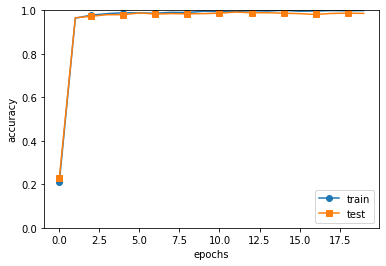

In [47]:
import pickle

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()